<a href="https://colab.research.google.com/github/BChun11/Data-projects/blob/main/financialmarkets_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
from datetime import datetime
import yfinance as yf
import pandas as pd
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
import lightgbm as lgb
import xgboost as xgb

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline

# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import BinaryAccuracy


In [ ]:
# Download Stock datasets

# Define the data sources
stocks = ['^IXIC', '^DJI', '^GSPC', '^N225', '^HSI', '^FTSE', '^GDAXI', '^AXJO']
currencies = ['EURUSD=X', 'AUDUSD=X', 'JPY=X', 'USDJPY=X']
commodities = ['SI=F', 'PL=F', 'CL=F', 'GC=F']  # Silver, Platinum, Oil, Gold

# Define the date range
start_date = '2000-01-04'
end_date = datetime.now().strftime('%Y-%m-%d')  # Get today's date

# Function to fetch data
def fetch_data_yfinance(symbols, start, end):
    data_frames = {}
    for symbol in symbols:
        try:
            data = yf.download(symbol, start=start, end=end)
            data_frames[symbol] = data
            print(f"Data fetched for {symbol}")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
    return data_frames

# Fetching data using yfinance
stock_data = fetch_data_yfinance(stocks, start_date, end_date)
currency_data = fetch_data_yfinance(currencies, start_date, end_date)
commodity_data = fetch_data_yfinance(commodities, start_date, end_date)

# Example: Display the first few rows of NASDAQ data
print(stock_data['^IXIC'].head())

[*********************100%%**********************]  1 of 1 completed


Data fetched for ^IXIC


[*********************100%%**********************]  1 of 1 completed


Data fetched for ^DJI


[*********************100%%**********************]  1 of 1 completed


Data fetched for ^GSPC


[*********************100%%**********************]  1 of 1 completed


Data fetched for ^N225


[*********************100%%**********************]  1 of 1 completed


Data fetched for ^HSI


[*********************100%%**********************]  1 of 1 completed


Data fetched for ^FTSE


[*********************100%%**********************]  1 of 1 completed


Data fetched for ^GDAXI


[*********************100%%**********************]  1 of 1 completed


Data fetched for ^AXJO


[*********************100%%**********************]  1 of 1 completed


Data fetched for EURUSD=X


[*********************100%%**********************]  1 of 1 completed


Data fetched for AUDUSD=X


[*********************100%%**********************]  1 of 1 completed


Data fetched for JPY=X


[*********************100%%**********************]  1 of 1 completed


Data fetched for USDJPY=X


[*********************100%%**********************]  1 of 1 completed


Data fetched for SI=F


[*********************100%%**********************]  1 of 1 completed


Data fetched for PL=F


[*********************100%%**********************]  1 of 1 completed


Data fetched for CL=F


[*********************100%%**********************]  1 of 1 completed

Data fetched for GC=F
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-04  4020.000000  4073.250000  3898.229980  3901.689941  3901.689941   
2000-01-05  3854.350098  3924.209961  3734.870117  3877.540039  3877.540039   
2000-01-06  3834.439941  3868.760010  3715.620117  3727.129883  3727.129883   
2000-01-07  3711.090088  3882.669922  3711.090088  3882.620117  3882.620117   
2000-01-10  4002.229980  4072.360107  3958.830078  4049.669922  4049.669922   

                Volume  
Date                    
2000-01-04  1511840000  
2000-01-05  1735670000  
2000-01-06  1598320000  
2000-01-07  1634930000  
2000-01-10  1691710000  


### Pre-processing

### Feature Engineering

- Add several technical indicators to each DataFrame in 'stock_data', 'currency_data' and 'commodity_data'.
- Indicators include Moving Averages, Exponential Moving Averages, Bollinger Bands and Relative Strength Index

In [ ]:
def add_technical_indicators(df):
    # Moving Average
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_10'] = df['Close'].rolling(window=10).mean()

    # Exponential Moving Average
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

    # Bollinger Bands
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['Upper_BB'] = df['MA_20'] + (df['BB_std'] * 2)
    df['Lower_BB'] = df['MA_20'] - (df['BB_std'] * 2)

    # Relative Strength Index (RSI)
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    #return df
    return df.dropna()

# Applying the function to each DataFrame in your datasets
for key in stock_data:
    stock_data[key] = add_technical_indicators(stock_data[key])

for key in currency_data:
    currency_data[key] = add_technical_indicators(currency_data[key])

for key in commodity_data:
    commodity_data[key] = add_technical_indicators(commodity_data[key])


In [ ]:
stock_data

{'^IXIC':                     Open          High           Low         Close  \
 Date                                                                 
 2000-02-01   3961.070068   4053.159912   3911.840088   4051.979980   
 2000-02-02   4059.030029   4125.750000   4051.439941   4073.959961   
 2000-02-03   4134.649902   4211.060059   4085.530029   4210.979980   
 2000-02-04   4242.149902   4294.839844   4229.200195   4244.140137   
 2000-02-07   4274.029785   4321.959961   4244.740234   4321.770020   
 ...                  ...           ...           ...           ...   
 2024-05-24  16786.789062  16947.800781  16771.580078  16920.789062   
 2024-05-28  16988.310547  17032.660156  16917.509766  17019.880859   
 2024-05-29  16879.349609  16989.599609  16873.970703  16920.580078   
 2024-05-30  16878.630859  16900.460938  16690.359375  16737.080078   
 2024-05-31  16771.900391  16789.269531  16445.539062  16735.019531   
 
                Adj Close      Volume          MA_5         MA_10 

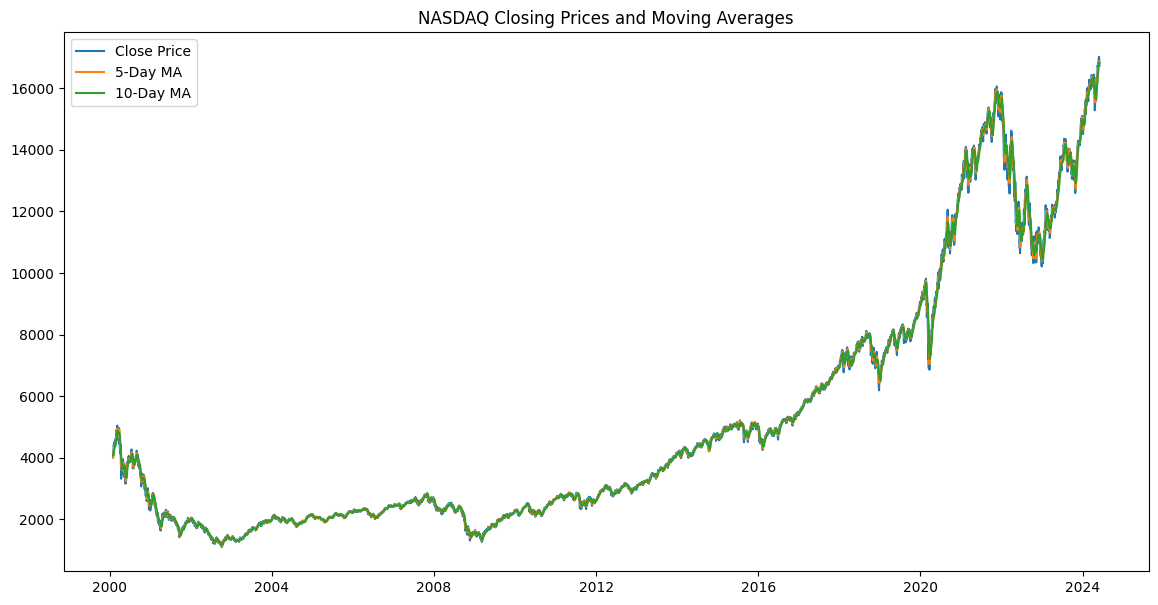

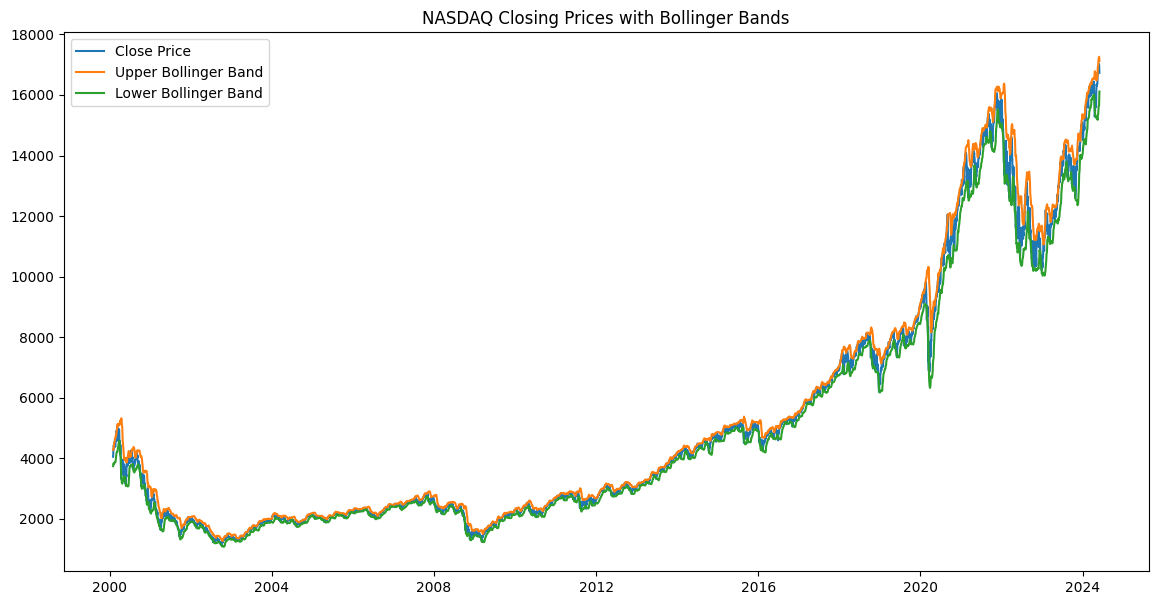

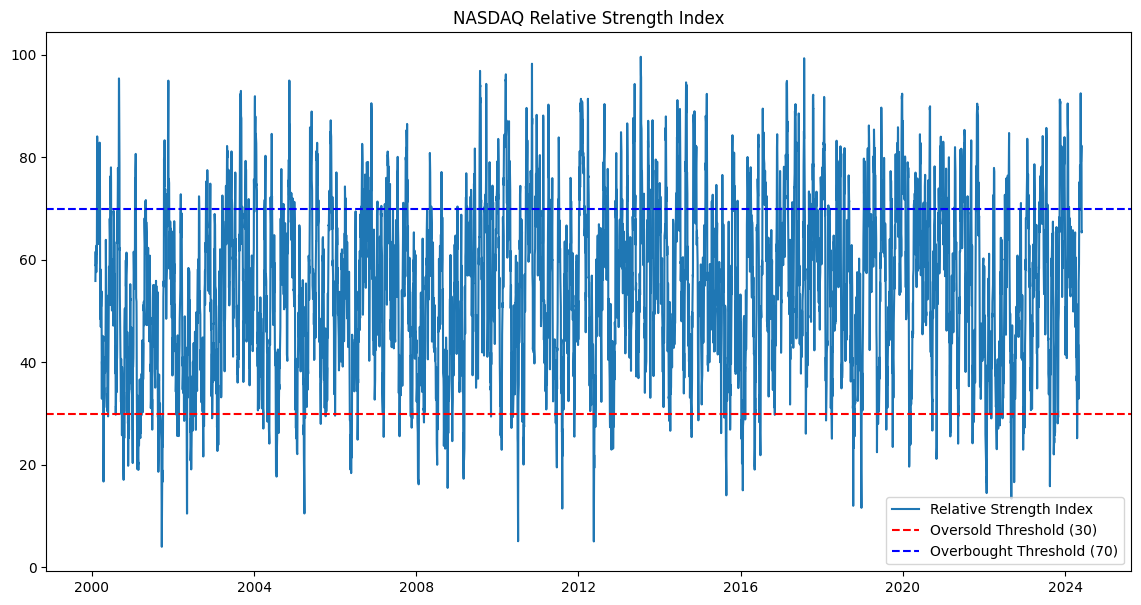

In [ ]:
# Select NASDAQ data
nasdaq_data = stock_data['^IXIC']

# Plotting the Closing Price and Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data['Close'], label='Close Price')
plt.plot(nasdaq_data['MA_5'], label='5-Day MA')
plt.plot(nasdaq_data['MA_10'], label='10-Day MA')
plt.title('NASDAQ Closing Prices and Moving Averages')
plt.legend()
plt.show()

# Plotting Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data['Close'], label='Close Price')
plt.plot(nasdaq_data['Upper_BB'], label='Upper Bollinger Band')
plt.plot(nasdaq_data['Lower_BB'], label='Lower Bollinger Band')
plt.title('NASDAQ Closing Prices with Bollinger Bands')
plt.legend()
plt.show()

# Plotting RSI
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data['RSI'], label='Relative Strength Index')
plt.axhline(30, color='red', linestyle='--', label='Oversold Threshold (30)')
plt.axhline(70, color='blue', linestyle='--', label='Overbought Threshold (70)')
plt.title('NASDAQ Relative Strength Index')
plt.legend()
plt.show()

#### Creating Differential Features

- Calculates the daily change in values for each financial instrument

It does the following:
- It iterates through each DataFrame in the collection and computes the difference in the 'Close' price between each day and the previous day.
- It adds a new column called 'Daily Change' to each DataFrame, which containes these calculated daily changes.

In [ ]:
def create_differential_features(data_frames):
    for key in data_frames:
        data_frames[key]['Daily Change'] = data_frames[key]['Close'].diff()
    return data_frames

stock_data = create_differential_features(stock_data)
currency_data = create_differential_features(currency_data)
commodity_data = create_differential_features(commodity_data)

print(stock_data['^IXIC'].head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-02-01  3961.070068  4053.159912  3911.840088  4051.979980  4051.979980   
2000-02-02  4059.030029  4125.750000  4051.439941  4073.959961  4073.959961   
2000-02-03  4134.649902  4211.060059  4085.530029  4210.979980  4210.979980   
2000-02-04  4242.149902  4294.839844  4229.200195  4244.140137  4244.140137   
2000-02-07  4274.029785  4321.959961  4244.740234  4321.770020  4321.770020   

                Volume         MA_5        MA_10       EMA_10        MA_20  \
Date                                                                         
2000-02-01  1398240000  3997.774023  4082.856006  4030.898732  4009.535498   
2000-02-02  1527880000  3998.584033  4075.122998  4038.728046  4018.148999   
2000-02-03  1722330000  4032.868018  4077.270020  4070.046580  4034.820996   
2000-02-04  1751450000  4104.282031  4078.144043  4101.6

<ipython-input-6-fcafbff3ee89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frames[key]['Daily Change'] = data_frames[key]['Close'].diff()


#### Align the datasets to the trading days of NASDAQ

In [ ]:
# Get NASDAQ Trading Days
nasdaq_trading_days = stock_data['^IXIC'].index

In [ ]:
def check_missing_values(data_frames):
    for key in data_frames:
        print(f"Missing values in {key}:")
        print(data_frames[key].isnull().sum())

# Checking for missing values in each dataset
print("Checking Stock Data for Missing Values:")
check_missing_values(stock_data)

print("\nChecking Currency Data for Missing Values:")
check_missing_values(currency_data)

print("\nChecking Commodity Data for Missing Values:")
check_missing_values(commodity_data)

Checking Stock Data for Missing Values:
Missing values in ^IXIC:
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
MA_5            0
MA_10           0
EMA_10          0
MA_20           0
BB_std          0
Upper_BB        0
Lower_BB        0
RSI             0
Daily Change    1
dtype: int64
Missing values in ^DJI:
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
MA_5            0
MA_10           0
EMA_10          0
MA_20           0
BB_std          0
Upper_BB        0
Lower_BB        0
RSI             0
Daily Change    1
dtype: int64
Missing values in ^GSPC:
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
MA_5            0
MA_10           0
EMA_10          0
MA_20           0
BB_std          0
Upper_BB        0
Lower_BB        0
RSI             0
Daily Change    1
dtype: int64
Missing values in ^N225:
Open        

In [ ]:
# Function to Align Data
def align_data_with_nasdaq(data_frames, nasdaq_dates):
    aligned_data = {}
    for key, df in data_frames.items():
        # Aligning with NASDAQ trading days
        df_aligned = df.reindex(nasdaq_dates)
        # Interpolate missing data
        df_aligned.interpolate(method='time', inplace=True)
        """
        # Forward fill any remaining missing values
        df_aligned.fillna(method='ffill', inplace=True)
        # Backward fill any remaining missing values
        df_aligned.fillna(method='bfill', inplace=True)
        """
        aligned_data[key] = df_aligned
    return aligned_data

# Aligning all datasets
aligned_stock_data = align_data_with_nasdaq(stock_data, nasdaq_trading_days)
aligned_currency_data = align_data_with_nasdaq(currency_data, nasdaq_trading_days)
aligned_commodity_data = align_data_with_nasdaq(commodity_data, nasdaq_trading_days)


In [ ]:
# Display the first few rows of aligned NASDAQ data
print(aligned_stock_data['^IXIC'].head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-02-01  3961.070068  4053.159912  3911.840088  4051.979980  4051.979980   
2000-02-02  4059.030029  4125.750000  4051.439941  4073.959961  4073.959961   
2000-02-03  4134.649902  4211.060059  4085.530029  4210.979980  4210.979980   
2000-02-04  4242.149902  4294.839844  4229.200195  4244.140137  4244.140137   
2000-02-07  4274.029785  4321.959961  4244.740234  4321.770020  4321.770020   

                Volume         MA_5        MA_10       EMA_10        MA_20  \
Date                                                                         
2000-02-01  1398240000  3997.774023  4082.856006  4030.898732  4009.535498   
2000-02-02  1527880000  3998.584033  4075.122998  4038.728046  4018.148999   
2000-02-03  1722330000  4032.868018  4077.270020  4070.046580  4034.820996   
2000-02-04  1751450000  4104.282031  4078.144043  4101.6

#### Normalisation

In [ ]:
# Normalise features using Min-Max scaling
def normalize_data(data_frames):
    scaler = MinMaxScaler()
    for key in data_frames:
        data_frames[key][['Daily Change']] = scaler.fit_transform(data_frames[key][['Daily Change']])
    return data_frames

stock_data = normalize_data(stock_data)
currency_data = normalize_data(currency_data)
commodity_data = normalize_data(commodity_data)


<ipython-input-11-c5980bc3cc0a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frames[key][['Daily Change']] = scaler.fit_transform(data_frames[key][['Daily Change']])


In [ ]:
# Example: Check the first few rows of NASDAQ data after preprocessing
print(stock_data['^IXIC'].head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-02-01  3961.070068  4053.159912  3911.840088  4051.979980  4051.979980   
2000-02-02  4059.030029  4125.750000  4051.439941  4073.959961  4073.959961   
2000-02-03  4134.649902  4211.060059  4085.530029  4210.979980  4210.979980   
2000-02-04  4242.149902  4294.839844  4229.200195  4244.140137  4244.140137   
2000-02-07  4274.029785  4321.959961  4244.740234  4321.770020  4321.770020   

                Volume         MA_5        MA_10       EMA_10        MA_20  \
Date                                                                         
2000-02-01  1398240000  3997.774023  4082.856006  4030.898732  4009.535498   
2000-02-02  1527880000  3998.584033  4075.122998  4038.728046  4018.148999   
2000-02-03  1722330000  4032.868018  4077.270020  4070.046580  4034.820996   
2000-02-04  1751450000  4104.282031  4078.144043  4101.6

## Exploratory Data Analysis

In [ ]:
# Statistical Summary
for key, df in stock_data.items():
    print(f"Statistics for {key}:\n{df.describe()}\n")

Statistics for ^IXIC:
               Open          High           Low         Close     Adj Close  \
count   6122.000000   6122.000000   6122.000000   6122.000000   6122.000000   
mean    5155.299328   5191.611567   5114.845049   5155.418963   5155.418963   
std     4078.029465   4105.237686   4047.788405   4078.631045   4078.631045   
min     1116.760010   1135.890015   1108.489990   1114.109985   1114.109985   
25%     2174.689941   2187.785034   2158.929993   2174.762512   2174.762512   
50%     3140.659912   3161.825073   3118.825073   3142.219971   3142.219971   
75%     7159.045044   7220.187622   7084.610107   7152.822388   7152.822388   
max    16996.390625  17032.660156  16917.509766  17019.880859  17019.880859   

             Volume          MA_5         MA_10        EMA_10         MA_20  \
count  6.122000e+03   6122.000000   6122.000000   6122.000000   6122.000000   
mean   2.457549e+09   5151.222925   5146.013965   5146.054565   5135.700267   
std    1.268519e+09   4072.48

In [ ]:
for key, df in currency_data.items():
    print(f"Statistics for {key}:\n{df.describe()}\n")

Statistics for EURUSD=X:
              Open         High          Low        Close    Adj Close  \
count  5303.000000  5303.000000  5303.000000  5303.000000  5303.000000   
mean      1.233535     1.238097     1.228539     1.233548     1.233548   
std       0.127633     0.128396     0.127915     0.127629     0.127629   
min       0.959619     0.967006     0.072902     0.959619     0.959619   
25%       1.122120     1.125936     1.118793     1.122208     1.122208   
50%       1.219304     1.224800     1.215658     1.219393     1.219393   
75%       1.328242     1.333227     1.322512     1.328348     1.328348   
max       1.598184     1.602821     1.587402     1.598798     1.598798   

       Volume         MA_5        MA_10       EMA_10        MA_20  \
count  5303.0  5303.000000  5303.000000  5303.000000  5303.000000   
mean      0.0     1.233608     1.233681     1.233678     1.233817   
std       0.0     0.127381     0.127172     0.127006     0.126755   
min       0.0     0.968951     0

In [ ]:
for key, df in commodity_data.items():
    print(f"Statistics for {key}:\n{df.describe()}\n")

Statistics for SI=F:
              Open         High          Low        Close    Adj Close  \
count  5942.000000  5942.000000  5942.000000  5942.000000  5942.000000   
mean     16.763648    16.876587    16.639090    16.757466    16.757466   
std       8.330433     8.420260     8.230486     8.324432     8.324432   
min       4.026000     4.026000     4.026000     4.026000     4.026000   
25%      11.280000    11.357500    11.146250    11.270000    11.270000   
50%      16.620001    16.701000    16.532500    16.624499    16.624499   
75%      22.223750    22.348000    22.010000    22.176250    22.176250   
max      48.459999    49.520000    47.540001    48.584000    48.584000   

              Volume         MA_5        MA_10       EMA_10        MA_20  \
count    5942.000000  5942.000000  5942.000000  5942.000000  5942.000000   
mean     1465.210030    16.748628    16.737550    16.737838    16.716308   
std      8563.666961     8.315185     8.305195     8.297709     8.286665   
min     

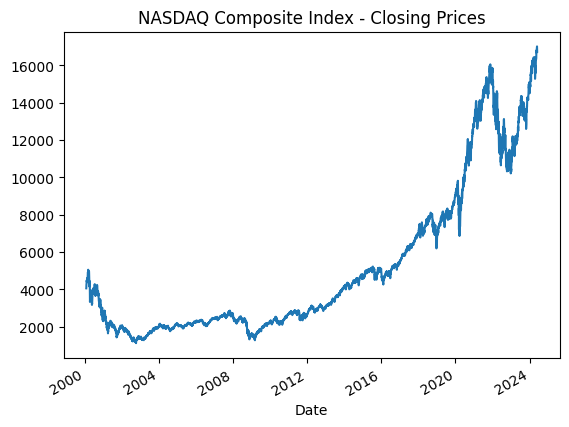

In [ ]:
# Visualise NASDAQ Composite Index - Closing Prices
stock_data['^IXIC']['Close'].plot(title='NASDAQ Composite Index - Closing Prices')
plt.show()

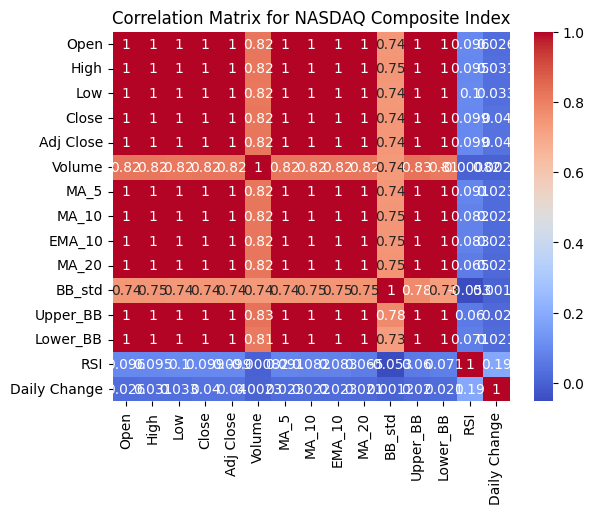

In [ ]:
# Correlation Analysis
sns.heatmap(stock_data['^IXIC'].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for NASDAQ Composite Index')
plt.show()

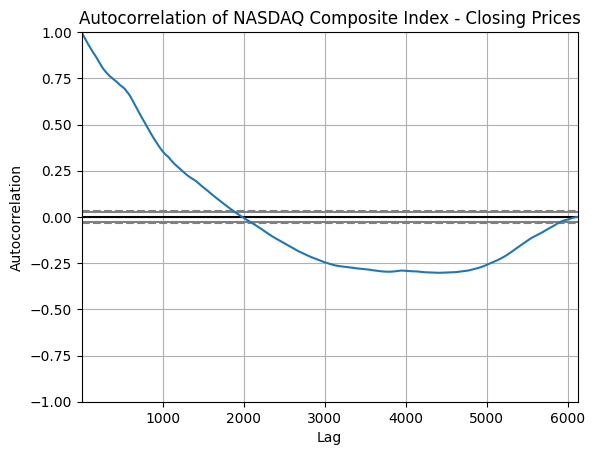

In [ ]:
# Autocorrelation Plot - Shows how the index's closing prices correlate with itself across different lags
autocorrelation_plot(stock_data['^IXIC']['Close'])
plt.title('Autocorrelation of NASDAQ Composite Index - Closing Prices')
plt.show()

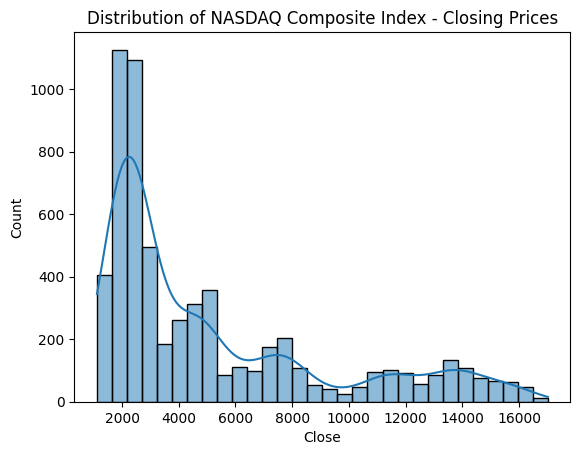

In [ ]:
# Distribution Plots
sns.histplot(stock_data['^IXIC']['Close'], kde=True)
plt.title('Distribution of NASDAQ Composite Index - Closing Prices')
plt.show()

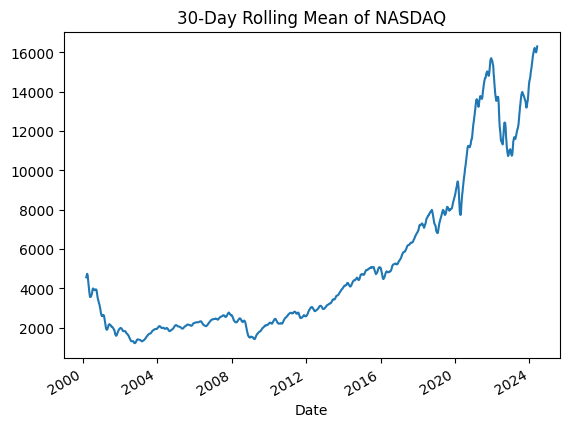

In [ ]:
# NASDAQ Trend Analysis
stock_data['^IXIC']['Close'].rolling(window=30).mean().plot(title='30-Day Rolling Mean of NASDAQ')
plt.show()

In [ ]:
# Checking for Stationarity - (Time series models require data to be stationary)
from statsmodels.tsa.stattools import adfuller
result = adfuller(stock_data['^IXIC']['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.893516
p-value: 0.998518


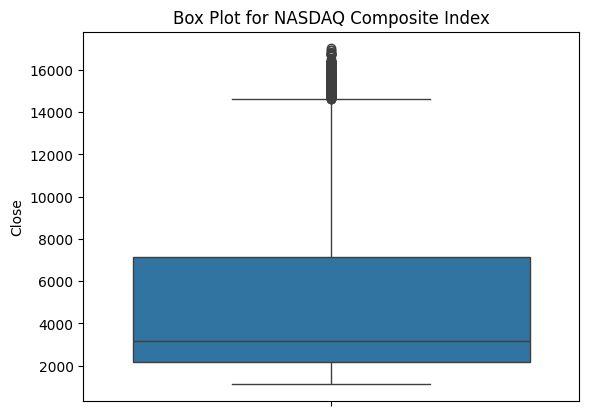

In [ ]:
sns.boxplot(stock_data['^IXIC']['Close'])
plt.title('Box Plot for NASDAQ Composite Index')
plt.show()

### **** Need to also plot for Commodities, Currencies vs NASDAQ

In [ ]:
def combine_data_frames(data_frames_dict):
    combined_data = pd.DataFrame()
    for symbol, df in data_frames_dict.items():
        # Use 'Close' price for each symbol; adjust as necessary
        combined_data[symbol] = df['Daily Change']

    # Ensure all data is aligned by date
    combined_data = combined_data.sort_index()
    return combined_data

# Combine all fetched data
combined_data_stocks = combine_data_frames(stock_data)
combined_data_currencies = combine_data_frames(currency_data)
combined_data_commodities = combine_data_frames(commodity_data)

# Merge all combined data on their indexes (dates)
combined_data = pd.concat([combined_data_stocks, combined_data_currencies, combined_data_commodities], axis=1, join='outer')


In [ ]:
combined_data

,^IXIC,^DJI,^GSPC,^N225,^HSI,^FTSE,^GDAXI,^AXJO,EURUSD=X,AUDUSD=X,JPY=X,USDJPY=X,SI=F,PL=F,CL=F,GC=F
Date,,,,,,,,,,,,,,,,
2000-02-01,NaN,NaN,NaN,NaN,0.496783,0.606177,0.650579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-02,0.573146,0.579101,0.584815,0.549095,0.500069,0.596554,0.609877,0.656510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-03,0.639594,0.588511,0.613647,0.567141,0.509706,0.605352,0.636390,0.649777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-04,0.579603,0.576793,0.584022,0.487012,NaN,0.457978,0.596303,0.586101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-07,0.605290,0.575155,0.584869,0.558389,NaN,0.524792,0.492273,0.633915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,0.617686,0.544095,0.587480,0.479596,0.467717,0.527542,0.514701,0.588497,0.478467,0.500478,0.507000,0.507000,0.902510,0.658287,0.560267,0.698202
2024-05-29,0.503093,0.506015,0.514705,0.391463,0.390799,0.520484,0.467735,0.497775,0.472677,0.499960,0.520250,0.520250,0.746058,0.615233,0.534093,0.537244
2024-05-30,0.454458,0.521918,0.528427,0.320554,0.412950,0.629639,0.567161,0.570467,0.463129,0.499608,0.518122,0.518122,0.629803,0.623863,0.527139,0.612157


In [ ]:
# Let's also assume '^IXIC' represents the NASDAQ index in your DataFrame

# Shift the NASDAQ 'Daily Change' column to create a target variable for next-day movement prediction
combined_data['NASDAQ_next_day_movement'] = combined_data['^IXIC'].shift(-1)
combined_data.dropna(inplace=True)  # Drop rows created with NaN values due to the shift

# Select features and target
X = combined_data.drop(['NASDAQ_next_day_movement', '^IXIC'], axis=1)  # Drop the NASDAQ column if it's not used as a feature
y = combined_data['NASDAQ_next_day_movement'].apply(lambda x: 1 if x > 0 else 0)  # Convert to binary outcome: 1 for increase, 0 for decrease

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# X_scaled = scaler.fit_transform(X)

# Now, X_scaled is ready for use in machine learning models, and y is your target variable.


In [ ]:
# Number of lags (days) for correlation - adjust as needed
num_lags = 5

# Initialize a DataFrame to store correlations
correlations = pd.DataFrame(index=range(-num_lags, num_lags + 1))

# Compute cross-correlation for each market
for column in combined_data.columns:
    if column != '^IXIC':  # Exclude NASDAQ itself
        correlations[column] = [combined_data['^IXIC'].corr(combined_data[column].shift(lag)) for lag in range(-num_lags, num_lags + 1)]


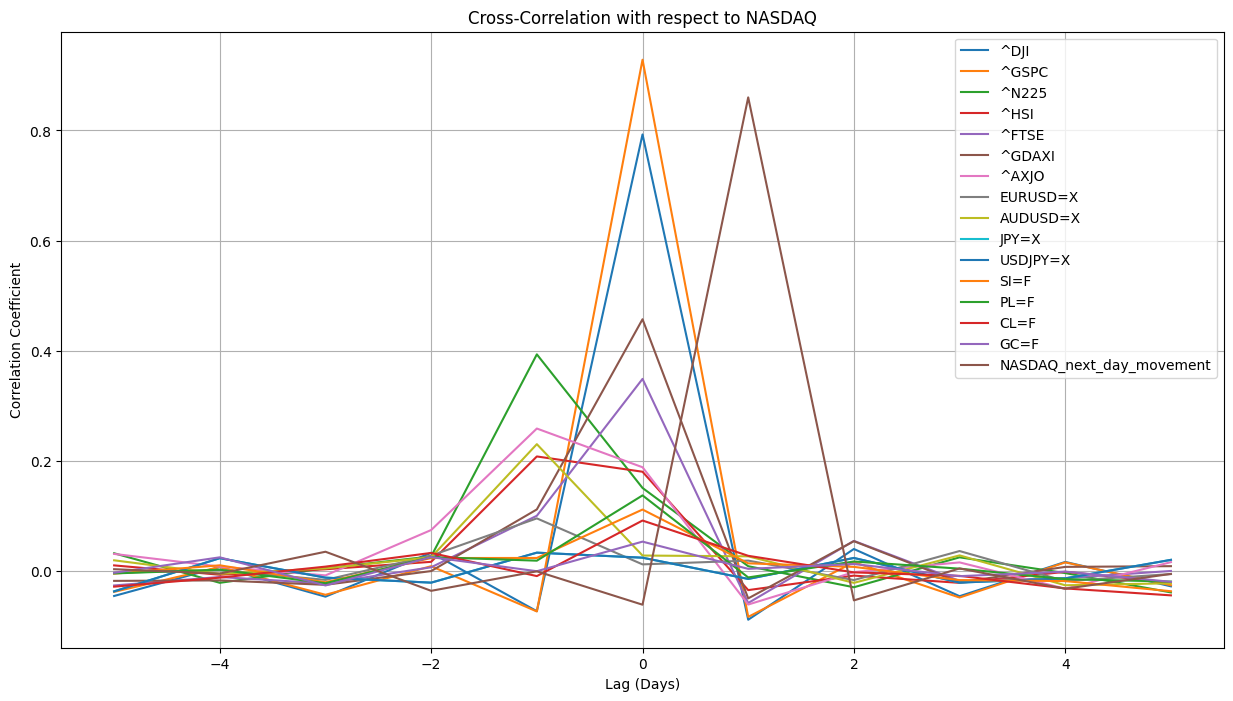

In [ ]:
# Plotting
plt.figure(figsize=(15, 8))
for column in correlations.columns:
    plt.plot(correlations.index, correlations[column], label=column)

plt.title('Cross-Correlation with respect to NASDAQ')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.show()


### Model Implementations

In [ ]:
# Assuming 'aligned_stock_data' is a dictionary of dataframes where each dataframe contains the stock features.
# Let's say we're predicting whether the NASDAQ (^IXIC) will go up or down. We will use 'Daily Change' as our target variable.

# Prepare the features and target variable
X = aligned_stock_data['^IXIC'].drop(['Daily Change'], axis=1)  # Your features
y = aligned_stock_data['^IXIC']['Daily Change'].apply(lambda x: 1 if x > 0 else 0)  # Binary target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### SVM Model Implementation

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 4 features based on ANOVA F-value
selector = SelectKBest(f_classif, k=4)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
features = selector.get_support(indices=True)
selected_feature_names = [X_train.columns[i] for i in features]
print("Selected features:", selected_feature_names)


Selected features: ['Low', 'Close', 'Adj Close', 'RSI']


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define a pipeline combining a standard scaler and the SVM model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Parameter grid for GridSearchCV
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.001, 0.01, 0.1, 'scale'],
    'svm__kernel': ['rbf']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_selected, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation accuracy: 61.90%


In [ ]:
# Use the best estimator to make predictions on the test set
y_pred = grid_search.predict(X_test_selected)

# Calculate accuracy and display the classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Selected Features: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy with Selected Features: 62.78%
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.45      0.53       574
           1       0.62      0.78      0.69       651

    accuracy                           0.63      1225
   macro avg       0.63      0.62      0.61      1225
weighted avg       0.63      0.63      0.62      1225

Confusion Matrix:
[[260 314]
 [142 509]]


In [ ]:
# Create an SVM model with a pipeline that includes scaling
# Using a pipeline ensures that scaling is correctly applied during both training and prediction
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

# Train the model
svm_pipeline.fit(X_train, y_train)

# Test the model's accuracy
accuracy = svm_pipeline.score(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Predictions
y_pred = svm_pipeline.predict(X_test)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Model Accuracy: 62.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.39      0.49       574
           1       0.61      0.82      0.70       651

    accuracy                           0.62      1225
   macro avg       0.63      0.61      0.60      1225
weighted avg       0.63      0.62      0.60      1225

Confusion Matrix:
[[225 349]
 [115 536]]


#### Random Forest

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Test the model's accuracy
accuracy = rf_classifier.score(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Predictions
y_pred = rf_classifier.predict(X_test)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Model Accuracy: 65.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       574
           1       0.66      0.74      0.70       651

    accuracy                           0.66      1225
   macro avg       0.66      0.65      0.65      1225
weighted avg       0.66      0.66      0.66      1225

Confusion Matrix:
[[327 247]
 [172 479]]


#### Cross Validation with Random Search

In [ ]:
# Define hyperparameters for Random Forest
param_rf = {
    'n_estimators': randint(100, 500),  # Increased range for more options
    'max_depth': [None] + list(randint(10, 100).rvs(10)),  # Adjusted depth range
    'min_samples_split': randint(2, 20),  # Narrowed for more relevant splits
    'min_samples_leaf': randint(1, 20),  # Narrowed for more relevant leaf sizes
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],  # Features to consider at each split
    'class_weight': [None, 'balanced']  # Handling imbalanced classes if needed
}

# Initialise Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialise RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_rf,
                                   n_iter=10, scoring='accuracy',  # Increased iterations, changed scoring to accuracy
                                   cv=3, random_state=42, n_jobs=-1, verbose=2)  # Added n_jobs and verbose for performance

# Fit the RandomizedSearchCV onto the train dataset
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
# Evaluate the best model
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Print the best parameters from the RandomizedSearchCV
print(f"Best parameters: {random_search.best_params_}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 66.86%
Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 58, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 393}

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.63       574
           1       0.67      0.73      0.70       651

    accuracy                           0.67      1225
   macro avg       0.67      0.66      0.66      1225
weighted avg       0.67      0.67      0.67      1225



#### LSTM Implementation

In [ ]:
# Assuming X_train, X_test are already defined

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Using sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model
_, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"LSTM Model Accuracy: {accuracy * 100:.2f}%")


Epoch 1/100
123/123 - 3s - loss: 0.6901 - binary_accuracy: 0.5320 - val_loss: 0.6843 - val_binary_accuracy: 0.5612 - 3s/epoch - 21ms/step
Epoch 2/100
123/123 - 0s - loss: 0.6874 - binary_accuracy: 0.5384 - val_loss: 0.6813 - val_binary_accuracy: 0.5612 - 396ms/epoch - 3ms/step
Epoch 3/100
123/123 - 0s - loss: 0.6856 - binary_accuracy: 0.5379 - val_loss: 0.6782 - val_binary_accuracy: 0.5602 - 397ms/epoch - 3ms/step
Epoch 4/100
123/123 - 0s - loss: 0.6831 - binary_accuracy: 0.5400 - val_loss: 0.6754 - val_binary_accuracy: 0.5724 - 391ms/epoch - 3ms/step
Epoch 5/100
123/123 - 0s - loss: 0.6817 - binary_accuracy: 0.5540 - val_loss: 0.6715 - val_binary_accuracy: 0.5857 - 399ms/epoch - 3ms/step
Epoch 6/100
123/123 - 0s - loss: 0.6798 - binary_accuracy: 0.5604 - val_loss: 0.6690 - val_binary_accuracy: 0.6000 - 421ms/epoch - 3ms/step
Epoch 7/100
123/123 - 0s - loss: 0.6777 - binary_accuracy: 0.5742 - val_loss: 0.6664 - val_binary_accuracy: 0.6112 - 373ms/epoch - 3ms/step
Epoch 8/100
123/123 - 

#### LightGBM Implementation

#### Feature Importance Function

In [ ]:
# Reference: https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

# Assuming 'best_lgbm' is your trained LightGBM model and 'X.columns' correctly reflects the features used by this model.

# Extract feature importances
def extract_feature_importances_lgbm(model, feature_names):
    return pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

# Plot feature importances
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending=True)
    n_features = df.shape[0]

    plt.figure(figsize=(8, n_features / 3))
    plt.barh(range(n_features), df['importance'], align='center')
    plt.yticks(range(n_features), df['feature'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_features)
    plt.show()


In [ ]:

# Defining the parameters for LightGBM model tailored for binary classification
lightgbm_param = {
    "objective": ["binary"],  # Adjusted for binary classification
    "boosting_type": ["gbdt"],
    "metric": ["binary_logloss", "auc"],  # Metrics suitable for binary classification
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": randint(20, 60).rvs(10),  # Adjusted range for num_leaves
    "max_depth": [-1] + list(randint(3, 10).rvs(5)),  # Adjusted range for max_depth
    "feature_fraction": [0.7, 0.8, 0.9, 1.0],
    "bagging_fraction": [0.7, 0.8, 0.9, 1.0],  # Added bagging_fraction for randomness
    "bagging_freq": [5]  # Bagging frequency
}

lgbm_clf = lgb.LGBMClassifier()

# Initialising RandomizedSearchCV for hyper-parameter tuning
random_search_lgbm = RandomizedSearchCV(estimator=lgbm_clf,
                                        param_distributions=lightgbm_param,
                                        n_iter=10,
                                        scoring='accuracy',  # Adjusted scoring to 'accuracy' for binary classification
                                        cv=5,
                                        random_state=42,
                                        verbose=1)  # Added verbosity for logging progress

# Fitting the RandomizedSearchCV onto the train dataset
random_search_lgbm.fit(X_train, y_train)

# Best parameters from the RandomizedSearchCV
best_lgbm = random_search_lgbm.best_estimator_
print(f"Best parameters: {random_search_lgbm.best_params_}")

# Evaluate the best model
y_pred = best_lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2128, number of negative: 1789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0008

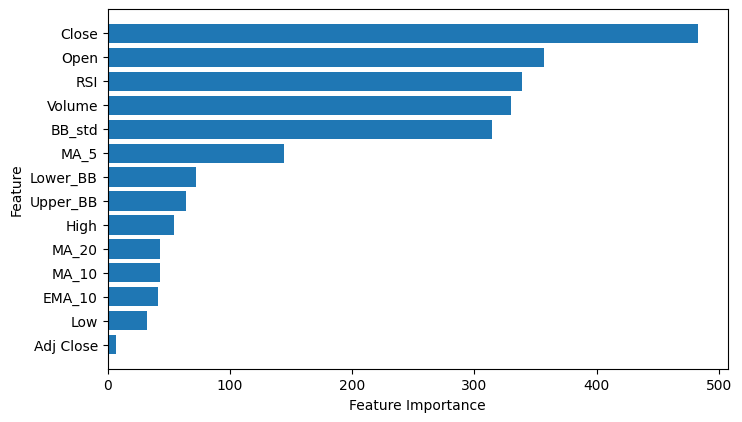

In [ ]:
# Plot feature importance
feature_importances_lgbm = extract_feature_importances_lgbm(best_lgbm, X.columns)
feature_importances_sorted_lgbm = plot_feature_importances(feature_importances_lgbm)

### XGBoost Implementation

In [ ]:
# Adjusting the hyperparameters for a binary classification task
xgb_param = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": randint(50, 250),
    "max_depth": [None] + list(randint(3, 10).rvs(5)),  # Simplified range
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 0.5),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "objective": ['binary:logistic'],  # Adjusted for binary classification
    # Removed num_class as it's not applicable
    "eval_metric": ["logloss", "auc"],  # Adjusted metrics for binary classification
    "seed": [42]
}

# Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False)

# Initialize RandomizedSearchCV for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(estimator=xgb_clf,
                                       param_distributions=xgb_param,
                                       n_iter=10,
                                       scoring='accuracy',  # Using 'accuracy' for binary classification
                                       cv=5,
                                       random_state=42)

# Fit RandomizedSearchCV on the train dataset
random_search_xgb.fit(X_train, y_train)

# Extracting the best estimator
best_xgb = random_search_xgb.best_estimator_

# Displaying the best parameters
print(f"Best parameters: {random_search_xgb.best_params_}")

# Evaluating the best model
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Displaying classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best parameters: {'colsample_bytree': 0.8059264473611898, 'eval_metric': 'auc', 'gamma': 0.023332831606807714, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 157, 'objective': 'binary:logistic', 'seed': 42, 'subsample': 0.7571172192068059}
Model Accuracy: 67.67%

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.59      0.63       574
           1       0.68      0.75      0.71       651

    accuracy                           0.68      1225
   macro avg       0.68      0.67      0.67      1225
weighted avg       0.68      0.68      0.67      1225

Confusion Matrix:
 [[339 235]
 [161 490]]


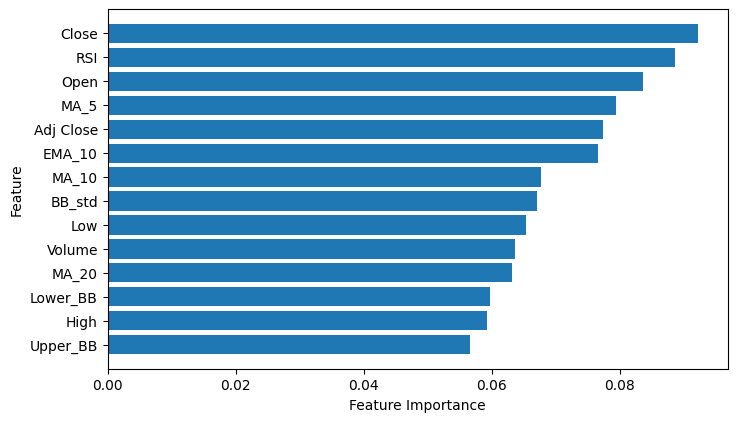

In [ ]:
# Extract feature importances from XGBoost model
def extract_feature_importances_xgb(model, feature_names):
    return pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })

feature_importances_xgb = extract_feature_importances_xgb(best_xgb, X.columns)
# Plot Feature Importance of XGB model
feature_importances_sorted_xgb = plot_feature_importances(feature_importances_xgb)